# FORCE: FORward modeling for Complex microstructure Estimation

This notebook demonstrates the FORCE framework for diffusion MRI analysis using the Stanford HARDI dataset. The pipeline includes:

1. **Data Loading**: Loading diffusion-weighted imaging (DWI) data
2. **Preprocessing**: Denoising and brain masking
3. **Simulation**: Generating a comprehensive library of synthetic diffusion signals
4. **Matching**: Using FAISS for fast similarity search to match real data to simulations
5. **Visualization**: Displaying tissue fractions, NODDI metrics, DTI metrics, and uncertainty maps

## Loading the Data

We start by loading the Stanford HARDI dataset, which includes:
- Diffusion-weighted images
- b-values (diffusion weighting)
- b-vectors (gradient directions)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import ray
from tqdm import tqdm
import faiss

from dipy.data import get_fnames, get_sphere, default_sphere
from dipy.denoise.patch2self import patch2self
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu
from dipy.sims.voxel import all_tensor_evecs
from dipy.core.sphere import Sphere
import dipy.reconst.dti as dti
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model

from faster_multitensor import multi_tensor
from utils.geometry import angle_between, is_angle_valid
from utils.distribution import bingham_dictionary



hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames(name="stanford_hardi")
data, affine = load_nifti(hardi_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals=bvals, bvecs=bvecs)


## Preprocessing: Denoising and Masking

Before analysis, we need to:
- **Denoise** the data using `patch2self` to improve signal quality
- **Create a brain mask** using `median_otsu` to focus analysis on brain tissue only

In [2]:
denoised_data = patch2self(data, bvals)
maskdata, mask = median_otsu(denoised_data, vol_idx=range(10, 50), numpass=4, median_radius = 4 , autocrop=False, dilate=2)

### Visualizing the Preprocessing Results

Let's visualize the denoised data and the generated mask to ensure preprocessing was successful.

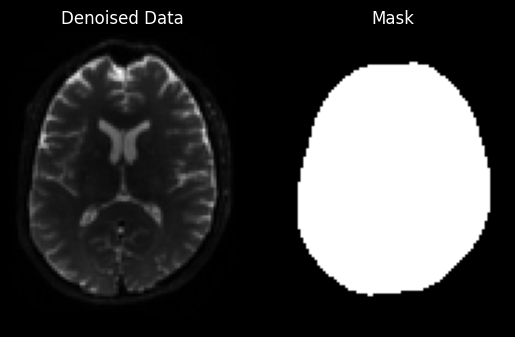

In [3]:
plt.figure(facecolor='black')
ax1 = plt.subplot(121)
ax1.imshow(denoised_data[:,:,36,0].T, cmap='gray', origin='lower')
ax1.set_title('Denoised Data', color='white')
ax1.axis('off')
ax2 = plt.subplot(122)
ax2.imshow(mask[:,:,36].T, cmap='gray', origin='lower')
ax2.set_title('Mask', color='white')
ax2.axis('off')
plt.show()



## Simulation Library Generation

Now that we have a valid brain mask, we generate a comprehensive library of synthetic diffusion signals. This library will be used to match real voxel signals and infer microstructural properties.

### Simulation Strategy

The simulation library includes:
- **Single, two, and three-fiber configurations** in white matter
- **Gray matter** (isotropic diffusion)
- **CSF** (cerebrospinal fluid, highly isotropic)
- **Mixed tissue** combinations with varying fractions

Each simulation includes:
- Diffusion signals matching the acquisition protocol
- Ground truth fiber orientations
- Microstructural parameters (ND, ODI, tissue fractions)
- DTI metrics (FA, MD, RD, AD)

In [4]:

sphere = get_sphere(name='repulsion724')
target_sphere = sphere.vertices

bvecs = np.ascontiguousarray(bvecs)

###################################### Simulation Functions ######################################

# list of odi values between 0.01 and 0.3 spaced out equally
odi_list = np.linspace(0.01, 0.3, 10)
evecs = np.array([all_tensor_evecs(tuple(point)) for point in target_sphere])
bingham_sf = bingham_dictionary(target_sphere, odi_list)

####################################### Global Variables #########################################
tortuisity = False
num_simulations = 500_000
wm_threshold = 0.5  # minimum white matter volume fraction for a voxel to have valid peaks
dtype_config = np.float32
label_dtype = np.uint8
num_cpus = 24


###################################### Helper ##########################################
def get_dperp_extra(d_par, f_intra):
    return d_par * (1 - f_intra) / (1 + f_intra)



###################################### Single fiber simulation ##########################################
def generate_single_fiber():
    """Generate a single-fiber diffusion signal with random parameters."""
    f_intra = np.random.uniform(0.6, 0.9)
    f_extra = 1 - f_intra

    fiber_fractions = 1.0

    labels = np.zeros((target_sphere.shape[0]), dtype=label_dtype)
    S0 = 100.0
    d_par = np.random.uniform(2.0e-3, 3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_intra)
    else:
        d_perp_extra = np.random.uniform(0.3e-3, 1.5e-3)

    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = d_perp_extra

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.0
    mevals_in[:, 2] = 0.0

    index = np.random.randint(0, target_sphere.shape[0], 1)[0]
    true_stick = target_sphere[index]
    factor = np.random.choice(odi_list)

    fodf_gt = bingham_sf[index][factor]
    fodf_gt = fodf_gt / np.sum(fodf_gt)

    S_in = multi_tensor(mevals_in, evecs, fodf_gt * 100, bvals, bvecs)
    S_ex = multi_tensor(mevals_ex, evecs, fodf_gt * 100, bvals, bvecs)

    S = fiber_fractions * (f_intra * S_in + f_extra * S_ex)

    labels[np.argmin(np.linalg.norm(target_sphere - true_stick, axis=1))] = 1

    # wm_d_perp returned here equals (1 - f_intra) * d_perp_extra
    return (
        S * S0,
        labels,
        1,
        factor,
        0.0,
        fiber_fractions * f_intra,  # wm_nd
        fodf_gt,
        d_par,
        f_extra * d_perp_extra,     # weighted
        [1.0, 0.0, 0.0],            # fiber fractions inside WM
        [f_intra],                  # f_ins per fiber
    )

###################################### Two fiber simulation ##########################################
def generate_two_fibers():
    """Generate a two-fiber diffusion signal with random parameters."""
    f_in = np.random.uniform(0.6, 0.9, 2)
    fiber_frac1 = np.random.uniform(0.2, 0.8)
    fiber_fractions = [fiber_frac1, 1 - fiber_frac1]

    d_par = np.random.uniform(2.0e-3, 3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_in[0])
    else:
        d_perp_extra = np.random.uniform(0.3e-3, 1.5e-3)

    labels = np.zeros((target_sphere.shape[0]), dtype=label_dtype)
    S0 = 100.0
    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = d_perp_extra

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.0
    mevals_in[:, 2] = 0.0

    index = np.random.randint(0, target_sphere.shape[0], 2)

    while not is_angle_valid(angle_between(target_sphere[index[0]], target_sphere[index[1]])):
        index = np.random.randint(0, target_sphere.shape[0], 2)

    true_stick1 = target_sphere[index[0]]
    true_stick2 = target_sphere[index[1]]
    factor = np.random.choice(odi_list)

    S = np.zeros((len(bvals)))
    fodf = np.zeros((target_sphere.shape[0]))
    for i in range(2):
        fodf_gt = bingham_sf[index[i]][factor]
        fodf_gt = fodf_gt / np.sum(fodf_gt)

        fodf += fiber_fractions[i] * fodf_gt

        S_in = multi_tensor(mevals_in, evecs, fodf_gt * 100, bvals, bvecs)
        S_ex = multi_tensor(mevals_ex, evecs, fodf_gt * 100, bvals, bvecs)

        f_intra = f_in[i]
        f_extra = 1 - f_intra

        S += fiber_fractions[i] * (f_intra * S_in + f_extra * S_ex)

        labels[np.argmin(np.linalg.norm(target_sphere - true_stick1, axis=1))] = 1
        labels[np.argmin(np.linalg.norm(target_sphere - true_stick2, axis=1))] = 1

    return (
        S * S0,
        labels,
        2,
        factor,
        0.0,
        fiber_fractions[0] * f_in[0] + fiber_fractions[1] * f_in[1],  # wm_nd
        fodf,
        d_par,
        fiber_fractions[0] * (1 - f_in[0]) * d_perp_extra + fiber_fractions[1] * (1 - f_in[1]) * d_perp_extra,
        [fiber_frac1, 1 - fiber_frac1, 0.0],
        f_in.tolist(),
    )

###################################### Three fiber simulation ##########################################
def generate_three_fibers():
    """Generate a three-fiber diffusion signal with random parameters."""
    f_in = np.random.uniform(0.6, 0.9, 3)
    fiber_fracs = np.random.dirichlet([1, 1, 1])
    while any(fiber_fracs < 0.2):
        fiber_fracs = np.random.dirichlet([1, 1, 1])

    d_par = np.random.uniform(2.0e-3, 3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_in[0])
    else:
        d_perp_extra = np.random.uniform(0.3e-3, 1.5e-3)

    labels = np.zeros((target_sphere.shape[0]), dtype=label_dtype)
    S0 = 100.0
    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = mevals_ex[:, 1]

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.0
    mevals_in[:, 2] = 0.0

    index = np.random.randint(0, target_sphere.shape[0], 3)

    while (
        not is_angle_valid(angle_between(target_sphere[index[0]], target_sphere[index[1]]), threshold=60)
        or not is_angle_valid(angle_between(target_sphere[index[0]], target_sphere[index[2]]), threshold=60)
        or not is_angle_valid(angle_between(target_sphere[index[1]], target_sphere[index[2]]), threshold=60)
    ):
        index = np.random.randint(0, target_sphere.shape[0], 3)

    true_stick1 = target_sphere[index[0]]
    true_stick2 = target_sphere[index[1]]
    true_stick3 = target_sphere[index[2]]
    factor = np.random.choice(odi_list)

    fodf = np.zeros((target_sphere.shape[0]))
    S = np.zeros((len(bvals)))
    for k in range(3):
        fodf_gt = bingham_sf[index[k]][factor]
        fodf_gt = fodf_gt / np.sum(fodf_gt)

        fodf += fiber_fracs[k] * fodf_gt

        S_in = multi_tensor(mevals_in, evecs, fodf_gt * 100, bvals, bvecs)
        S_ex = multi_tensor(mevals_ex, evecs, fodf_gt * 100, bvals, bvecs)

        S += fiber_fracs[k] * (f_in[k] * S_in + (1 - f_in[k]) * S_ex)

    labels[np.argmin(np.linalg.norm(target_sphere - true_stick1, axis=1))] = 1
    labels[np.argmin(np.linalg.norm(target_sphere - true_stick2, axis=1))] = 1
    labels[np.argmin(np.linalg.norm(target_sphere - true_stick3, axis=1))] = 1

    return (
        S * S0,
        labels,
        3,
        factor,
        0.0,
        fiber_fracs[0] * f_in[0] + fiber_fracs[1] * f_in[1] + fiber_fracs[2] * f_in[2],  # wm_nd
        fodf,
        d_par,
        fiber_fracs[0] * (1 - f_in[0]) * d_perp_extra + fiber_fracs[1] * (1 - f_in[1]) * d_perp_extra + fiber_fracs[2] * (1 - f_in[2]) * d_perp_extra,
        fiber_fracs.tolist(),
        f_in.tolist(),
    )

def create_wm_signal(num_fib):
    """Generate a white matter signal with random fiber configuration."""
    if num_fib == 1:
        return generate_single_fiber()
    elif num_fib == 2:
        return generate_two_fibers()
    elif num_fib == 3:
        return generate_three_fibers()

def create_gm_signal():
    """Generate a gray matter signal (isotropic)."""
    d = np.random.uniform(0.7e-3, 1.2e-3)
    signal = np.exp(-bvals * d) * 100.0
    return signal, np.zeros(len(target_sphere), dtype=label_dtype), 0, 1.0, 0.0, 0.0, np.ones(len(target_sphere)) / len(target_sphere), d, d

def create_csf_signal():
    """Generate a CSF signal (isotropic)."""
    d = 3.0e-3
    signal = np.exp(-bvals * d) * 100.0
    return signal, np.zeros(len(target_sphere), dtype=label_dtype), 0, 1.0, 1.0, 0.0, np.zeros(len(target_sphere)), d, d

################ Mixed tissue simulation #######################

def create_mixed_signal():
    """Generate a mixed signal combining WM, GM, and CSF."""

    # Randomly sample fractions for WM, GM, and CSF
    fractions = np.random.dirichlet([2.0, 1.0, 1.0])  # WM, GM, CSF
    wm_fraction = float(fractions[0])
    gm_fraction = float(fractions[1])
    csf_fraction = float(fractions[2])

    # Choose a random number of fibers for WM
    num_fiber = int(np.random.choice([1, 2, 3], p=[0.1, 0.2, 0.7]))

    # create signals for each tissue type
    wm_signal, wm_label, wm_num_fib, wm_disp, _, wm_nd, wm_odf, wm_d_par, wm_d_perp, fracs, f_ins = create_wm_signal(num_fib=num_fiber)
    gm_signal, _, _, gm_disp, _, gm_nd, gm_odf, gm_d_par, gm_d_perp = create_gm_signal()
    csf_signal, _, _, _, csf_fw, _, csf_odf, csf_d_par, csf_d_perp = create_csf_signal()

    # Combined ODI and ND
    odi = float(wm_fraction * wm_disp + gm_fraction * gm_disp + csf_fraction * 1.0)
    nd  = float(wm_fraction * wm_nd + gm_fraction * gm_nd)

    # Combine signals
    combined_signal = wm_fraction * wm_signal + gm_fraction * gm_signal + csf_fraction * csf_signal


    # If WM fraction is below threshold, set WM labels and ODF to zero for export
    if wm_fraction > wm_threshold:
        combined_odf = 50.0 * wm_fraction * wm_odf  # scaled for visualization
    else:
        wm_label = np.zeros(len(target_sphere), dtype=label_dtype)
        combined_odf = np.zeros(len(target_sphere), dtype=np.float16)
    

    # return all the metrics and signals
    # Indices must match the consumer loop below
    return (
        combined_signal,                    # 0
        wm_label,                           # 1
        wm_num_fib,                         # 2
        odi,                                # 3
        wm_fraction,                        # 4
        gm_fraction,                        # 5
        csf_fraction,                       # 6
        nd,                                 # 7
        combined_odf.astype(np.float16),    # 8
        fracs                                # 9 fiber fractions inside WM (len 1..3)
    )

@ray.remote
def generate_mixed():
    return create_mixed_signal()

################################## Main Simulation Loop ##########################################
ray.init(num_cpus=num_cpus,ignore_reinit_error=True)

results = []
futures = [generate_mixed.remote() for _ in range(num_simulations)]
for future in tqdm(futures, desc="Generating mixed signals"):
    results.append(ray.get(future))

##################################### Preallocation ##########################################
signals = np.zeros((num_simulations, len(bvals)), dtype=dtype_config)
labels = np.zeros((num_simulations, len(target_sphere)), dtype=label_dtype)
num_fibers = np.zeros(num_simulations, dtype=dtype_config)
dispersion = np.zeros(num_simulations, dtype=dtype_config)
wm_fraction_arr = np.zeros(num_simulations, dtype=dtype_config)
gm_fraction_arr = np.zeros(num_simulations, dtype=dtype_config)
csf_fraction_arr = np.zeros(num_simulations, dtype=dtype_config)
nd_arr = np.zeros(num_simulations, dtype=dtype_config)
odfs = np.zeros((num_simulations, len(target_sphere)), dtype=np.float16)
fraction_array = np.zeros((num_simulations, 3), dtype=dtype_config)


for i, res in enumerate(results):
    signals[i] = res[0]
    labels[i] = res[1]
    num_fibers[i] = res[2]
    dispersion[i] = res[3]
    wm_fraction_arr[i] = res[4]
    gm_fraction_arr[i] = res[5]
    csf_fraction_arr[i] = res[6]
    nd_arr[i] = res[7]
    odfs[i] = res[8]
    fraction_array[i] = res[9]

################################### DTI computation ##########################################
# Subset for DTI on lowest shell plus b0s
b0_mask = bvals <= 50

dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(signals)

fa_dti = dti_fit.fa.astype(dtype_config)
md_dti = dti_fit.md.astype(dtype_config)
rd_dti = dti_fit.rd.astype(dtype_config)
ad_dti = dti_fit.ad.astype(dtype_config)


2025-12-05 20:51:16,296	INFO worker.py:1781 -- Started a local Ray instance.


(raylet) Warning: The remote function __main__.generate_mixed is very large (40 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(generate_mixed pid=587086) /home/athshah/miniconda3/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
(generate_mixed pid=587086)   setattr(self, word, getattr(machar, word).flat[0])
(generate_mixed pid=587086) /home/athshah/miniconda3/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
(generate_mixed pid=587086)   return self._float_to_str(self.smallest_subnormal)
Generating mixed signals: 100%|██████████| 500000/500000 [03:39<00:00, 2273.37it/s]


## Matching Real Data to Simulation Library

Now that the simulation library is created, we perform matching on the real diffusion data. This process uses:

- **FAISS (Facebook AI Similarity Search)** for efficient nearest neighbor search
- **Cosine similarity** on normalized diffusion signals
- **GPU acceleration** for fast processing
- **Chunked processing** to handle large datasets efficiently


In [5]:
# Lets create empty arrays for the metrics
total_voxels = maskdata.shape[0] * maskdata.shape[1] * maskdata.shape[2]
voxel_flattened = np.empty((total_voxels, len(target_sphere)), dtype=label_dtype)
fa = np.empty(total_voxels, dtype=dtype_config)
md = np.empty(total_voxels, dtype=dtype_config)
rd = np.empty(total_voxels, dtype=dtype_config)
ad = np.empty(total_voxels, dtype=dtype_config)
fw = np.empty(total_voxels, dtype=dtype_config)
nd = np.empty(total_voxels, dtype=dtype_config)
odi = np.empty(total_voxels, dtype=dtype_config)
wm_fraction = np.empty(total_voxels, dtype=dtype_config)
gm_fraction = np.empty(total_voxels, dtype=dtype_config)
odfs_output = np.empty((total_voxels, len(target_sphere)), dtype=np.float16)
dwi = np.empty((total_voxels, len(bvals)), dtype=dtype_config)
fraction_output = np.empty((total_voxels, 3), dtype=dtype_config)
uncertainty = np.zeros(total_voxels, dtype=dtype_config)
ambiguity = np.zeros(total_voxels, dtype=dtype_config)
num_fibers_output = np.zeros(total_voxels, dtype=dtype_config)

maskdata_flattened = maskdata.reshape(-1, len(bvals))


# Create normalized vectors for signals and maskdata for cosine similarity

maskdata_norm = maskdata_flattened / np.linalg.norm(maskdata_flattened, axis=1, keepdims=True)
signals_norm = signals / np.linalg.norm(signals, axis=1, keepdims=True)

maskdata_norm = np.ascontiguousarray(maskdata_norm)
signals_norm = np.ascontiguousarray(signals_norm)


/tmp/ipykernel_586456/1000906785.py:25: RuntimeWarning: invalid value encountered in divide
  maskdata_norm = maskdata_flattened / np.linalg.norm(maskdata_flattened, axis=1, keepdims=True)


### Helper Functions for Matching

We define several helper functions:
- **`compute_uncertainty_and_ambiguity`**: Computes uncertainty (IQR) and ambiguity (FWHM fraction) from similarity profiles
- **`create_faiss_index`**: Creates a FAISS index for fast similarity search
- **`FaissActor`**: A Ray actor class that maintains a GPU-accelerated FAISS index for distributed matching

### Creating the FAISS Search Index

We create a GPU-accelerated FAISS index and a Ray actor to perform distributed similarity searches. The index uses:
- **Inner product** (cosine similarity) on normalized signals
- **Penalty mechanism** to prefer simpler fiber configurations
- **GPU resources** for fast computation


### Performing the Matching

We process the data in chunks to efficiently handle large datasets. For each chunk:
1. Normalize the voxel signals
2. Search for the 50 most similar simulations
3. Apply penalty based on fiber complexity
4. Select the best match
5. Extract all metrics from the matched simulation
6. Compute uncertainty and ambiguity measures

In [6]:
def compute_uncertainty_and_ambiguity(profile):
    """
    Compute uncertainty (IQR) and ambiguity (FWHM fraction) for each row of 'profile'.
    'profile' shape (N, M).
    """
    p75 = np.percentile(profile, 75, axis=1)
    p25 = np.percentile(profile, 25, axis=1)
    uncertainties = p75 - p25
    max_values = np.max(profile, axis=1)
    half_max = max_values / 2.0
    widths = np.sum(profile > half_max[:, None], axis=1)
    ambiguities = widths / profile.shape[1]
    return uncertainties.astype(np.float32), ambiguities.astype(np.float32)

def create_faiss_index(signal_array_norm):
    # cosine similarity via inner product on L2-normalized features
    dimension = signal_array_norm.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(signal_array_norm)  # base vectors
    return index

@ray.remote
def faiss_search(index, chunk_indices, maskdata_chunk_normalized, labels, penalized_array, profile_data):
    """
    Perform FAISS search with penalty adjustment.

    Returns:
      closest_labels: (Nchunk, 724)
      chunk_indices: 1D indices into flattened voxel space
      final_indices: (Nchunk,) best matching library indices
    """
    D, I = index.search(maskdata_chunk_normalized, k=50)
    # D shape (Nchunk, 50), I shape (Nchunk, 50)
    D = D - penalized_array[I]   # penalize by number of fibers
    best = np.argmax(D, axis=1)
    final_indices = I[np.arange(len(best)), best]
    uncertainty, ambiguity = compute_uncertainty_and_ambiguity(profile_data[I])
    closest_labels = labels[final_indices]
    return closest_labels, chunk_indices, final_indices, uncertainty, ambiguity

@ray.remote(num_gpus=1) # Request a GPU for this actor
class FaissActor:
    def __init__(self, signal_array_norm_data, labels_data, penalized_list_data, profile_data, device_id=0):
        # Initialize GPU resources once for the lifetime of this actor
        self.res = faiss.StandardGpuResources()

        dimension = signal_array_norm_data.shape[1]
        config = faiss.GpuIndexFlatConfig()
        config.device = device_id # Use a specific GPU device

        self.index = faiss.GpuIndexFlatIP(self.res, dimension, config)
        self.index.add(signal_array_norm_data.astype(np.float32))

        # Store other necessary data if it's static for all searches
        self.labels = labels_data
        self.penalized_array = penalized_list_data
        self.profile_data = profile_data

        # Make the helper function available to the actor, e.g., as a static method or defined here
        # For simplicity, assume compute_uncertainty_and_ambiguity is globally defined or passed if needed

    def search_chunk_actor(self, chunk_indices, maskdata_chunk_normalized):
        D, I = self.index.search(maskdata_chunk_normalized.astype(np.float32), k=50)

        penalties_for_neighbors = self.penalized_array[I]
        D = D - penalties_for_neighbors

        # Assuming compute_uncertainty_and_ambiguity is accessible
        uncertainty, ambiguity = compute_uncertainty_and_ambiguity(self.profile_data[I])

        best_indices_in_k = np.argmin(D, axis=1)
        final_indices_in_signal_array = I[np.arange(len(best_indices_in_k)), best_indices_in_k]

        closest_labels = self.labels[final_indices_in_signal_array]

        return closest_labels, chunk_indices, final_indices_in_signal_array, uncertainty, ambiguity

    def create_faiss_index(signal_array_norm):
        # Create a FAISS index for cosine similarity
        dimension = signal_array_norm.shape[1]
        index = faiss.IndexFlatIP(dimension) # Inner Product for cosine similarity
        index.add(signal_array_norm)  # Add normalized data to the index

        return index


In [7]:
penalty = 0.00001

penalized_list = penalty * num_fibers
signal_array_norm_ref = ray.put(signals_norm)
labels_ref = ray.put(labels)
penalized_list_ref = ray.put(penalized_list)
num_fibers_ref = ray.put(num_fibers)
use_gpu = False

######################################################### Using GPU #########################################################
######################################################### Turn the flag to False to use CPU #########################################################
if use_gpu:

    faiss_actor = FaissActor.remote(signal_array_norm_ref, labels_ref, penalized_list_ref, num_fibers_ref)
else:
    faiss_index = create_faiss_index(signals_norm)


### Memory Cleanup

After matching is complete, we delete large arrays that are no longer needed to free up memory.


## Postprocessing Peaks

The matching process returns binary labels indicating fiber orientations. We postprocess these to extract:
- Peak directions (3D coordinates)
- Peak indices (positions on the sphere)
- Peak values (fiber fractions)

This function ensures we have exactly 5 peaks per voxel (padded with zeros if fewer peaks are detected).


### Reshaping Peak Data

We reshape the peak data back to the original 3D volume dimensions and apply the brain mask to ensure peaks are only present in brain tissue.


### Reshaping All Output Metrics

We reshape all the output metrics back to the original 3D volume dimensions and apply the brain mask to ensure values are only present in brain tissue.


## Creating PeakObject for Downstream Analysis

We create a `PeakObject` class that stores all peak-related information in a format compatible with DIPY's peak analysis tools. This includes:
- Peak directions and indices
- ODF (Orientation Distribution Function) data
- GFA (Generalized Fractional Anisotropy) and QA (Quantitative Anisotropy) metrics
- SH (Spherical Harmonics) coefficients

**Note**: We use CSA (Constant Solid Angle) model to extract some class parameters, but the actual peaks come from our FORCE matching results.


In [ ]:
# Define chunk size and create chunks
chunk_size = 10000
num_chunks = int(np.ceil(maskdata_flattened.shape[0] / chunk_size))

# Create chunks of indices
chunks = [np.arange(i * chunk_size, min((i + 1) * chunk_size, maskdata_flattened.shape[0]), dtype=np.int32) 
        for i in range(num_chunks)]


signal_indices = np.arange(signals_norm.shape[0], dtype=np.int32)
res = []
res_futures = []
time_matching = time.time()
for i, chunk_idx_array in enumerate(chunks):
    print(f"Processing chunk {i + 1} of {num_chunks}...")
    maskdata_chunk = maskdata_norm[chunk_idx_array]
    maskdata_chunk_ref = ray.put(maskdata_chunk)

    # Call the actor's search method
    if use_gpu:
        res_futures.append(faiss_actor.search_chunk_actor.remote(
            chunk_idx_array,
            maskdata_chunk_ref
        ))
    else:
        res_futures.append(faiss_search.remote(
            faiss_index,
            chunk_idx_array,
            maskdata_chunk_ref,
            labels_ref,
            penalized_list_ref,
            num_fibers_ref
        ))

    # Process results (adjust batching logic as needed)
    if len(res_futures) >= 20 or (i == num_chunks - 1):
        results_batch = ray.get(res_futures)
        print("Now processing the results...", flush=True)
        for reslt in results_batch:
            # Unpack results: (closest_labels, returned_chunk_indices, final_indices_in_signal_array, uncertainty, ambiguity)
            closest_labels_val, returned_chunk_indices, final_indices, uncertainty_val, ambiguity_val = reslt
            voxel_flattened[returned_chunk_indices] = closest_labels_val
            # Use final_indices to look up in your original simulation arrays (dispersion, csf_fraction, etc.)
            odi[returned_chunk_indices] = dispersion[final_indices]
            fw[returned_chunk_indices] = csf_fraction_arr[final_indices]
            wm_fraction[returned_chunk_indices] = wm_fraction_arr[final_indices]
            gm_fraction[returned_chunk_indices] = gm_fraction_arr[final_indices]
            nd[returned_chunk_indices] = nd_arr[final_indices]
            odfs_output[returned_chunk_indices] = odfs[final_indices]
            num_fibers_output[returned_chunk_indices] = num_fibers[final_indices]
            dwi[returned_chunk_indices] = signals[final_indices]
            fa[returned_chunk_indices] = fa_dti[final_indices]
            md[returned_chunk_indices] = md_dti[final_indices]
            rd[returned_chunk_indices] = rd_dti[final_indices]
            ad[returned_chunk_indices] = ad_dti[final_indices]
            fraction_output[returned_chunk_indices] = fraction_array[final_indices]
            uncertainty[returned_chunk_indices] = uncertainty_val
            ambiguity[returned_chunk_indices] = ambiguity_val
        res_futures = []
print("Matching complete") 

Processing chunk 1 of 66...
Processing chunk 2 of 66...
Processing chunk 3 of 66...
Processing chunk 4 of 66...
Processing chunk 5 of 66...
Processing chunk 6 of 66...
Processing chunk 7 of 66...
Processing chunk 8 of 66...
Processing chunk 9 of 66...
Processing chunk 10 of 66...
Processing chunk 11 of 66...
Processing chunk 12 of 66...
Processing chunk 13 of 66...
Processing chunk 14 of 66...
Processing chunk 15 of 66...
Processing chunk 16 of 66...
Processing chunk 17 of 66...
Processing chunk 18 of 66...
Processing chunk 19 of 66...
Processing chunk 20 of 66...
Now processing the results...
Processing chunk 21 of 66...
Processing chunk 22 of 66...
Processing chunk 23 of 66...
Processing chunk 24 of 66...
Processing chunk 25 of 66...
Processing chunk 26 of 66...
Processing chunk 27 of 66...
Processing chunk 28 of 66...
Processing chunk 29 of 66...
Processing chunk 30 of 66...
Processing chunk 31 of 66...
Processing chunk 32 of 66...
Processing chunk 33 of 66...
Processing chunk 34 of

In [ ]:
### Memory Cleanup

# After matching is complete, we delete large arrays that are no longer needed to free up memory.
del signals_norm, labels, penalized_list, num_fibers, dispersion, wm_fraction_arr, gm_fraction_arr, csf_fraction_arr, nd_arr, odfs, fraction_array




In [ ]:
def postprocess_peaks(preds, target_sphere, fracs):
    """
    Postprocesses the peaks to return exactly 3 peaks per sample.

    Args:
        preds (np.ndarray): Binary array indicating peak positions.
        target_sphere (np.ndarray): Coordinates of all possible peaks.

    Returns:
        np.ndarray: Array of 3 peaks per sample.
        np.ndarray: Indices of the 3 peaks.
    """
    peaks_output = []
    peak_indices = []
    peak_vals = []

    for i in tqdm(range(preds.shape[0])):
        # Get the coordinates and indices of predicted peaks
        coords = target_sphere[preds[i] == 1]
        indices = np.where(preds[i] == 1)[0]
        vals = np.zeros(5)

        # Ensure exactly 3 peaks by padding with zeros if needed
        temp_peaks = np.zeros((5, 3))
        temp_indices = np.ones(5) * -1

        temp_peaks[:len(coords)] = coords
        temp_indices[:len(indices)] = indices
        vals[:len(fracs[i])] = fracs[i]

        peaks_output.append(temp_peaks)
        peak_indices.append(temp_indices)
        peak_vals.append(vals)

    return np.array(peaks_output), np.array(peak_indices), np.array(peak_vals)

peaks, peak_indices, peak_values = postprocess_peaks(voxel_flattened, target_sphere, fraction_output)

  0%|          | 0/652536 [00:00<?, ?it/s]

100%|██████████| 652536/652536 [00:03<00:00, 174367.73it/s]


In [ ]:
peaks_output = np.reshape(peaks,(mask.shape[0], mask.shape[1], mask.shape[2], 5, 3))
peak_indices = np.reshape(peak_indices,(mask.shape[0], mask.shape[1], mask.shape[2], 5))
peak_values = np.reshape(peak_values,(mask.shape[0], mask.shape[1], mask.shape[2], 5))

# make peaks output 0 where mask is 0 by
peaks_output = peaks_output * mask[..., None,None]
peak_indices = peak_indices * mask[..., None]
peak_values = peak_values * mask[..., None]

In [ ]:
# Reshape the outputs 
odi = odi.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
fw = fw.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
gm_fraction = gm_fraction.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
nd = nd.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
wm_fraction = wm_fraction.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
fw = fw.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
num_fibers_output = num_fibers_output.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
dwi = dwi.reshape(mask.shape[0], mask.shape[1], mask.shape[2], bvals.shape[0]) * mask[..., None]
fa = fa.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
md = md.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
rd = rd.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
ad = ad.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
uncertainty = uncertainty.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
ambiguity = ambiguity.reshape(mask.shape[0], mask.shape[1], mask.shape[2]) * mask
odf_output = odfs_output.reshape(mask.shape[0], mask.shape[1], mask.shape[2], len(target_sphere)) * mask[..., None]


In [ ]:

# We need CSA to get some class parameters to save PeakObject but we don't use the variables
# for anything else. Downstream tasks uses the peaks directly.
csa_model = CsaOdfModel(gtab, sh_order_max=6)
csa_peaks = peaks_from_model(csa_model, maskdata, default_sphere,
                                    relative_peak_threshold=.5,
                                    min_separation_angle=45,
                                    parallel=True,mask=mask, normalize_peaks=True)


class PeakObject:
    """
    Class to represent peak-related information.

    Attributes:
        peak_dirs (List[Any]): Directions of the peaks.
        affine (List[List[float]]): Affine transformation matrix.
        peak_values (List[float]): Values associated with each peak.
    """
    def __init__(self, peak_dirs, peak_values, peak_indices, affine):
        """
        Initialize a PeakObject instance.
        
        Parameters:
            peak_dirs (List[Any]): Directions of the peaks.
            affine (List[List[float]]): Affine transformation matrix.
            peak_values (List[float]): Values associated with each peak.
        """
        self.peak_dirs = peak_dirs
        self.affine = affine
        self.peak_values = peak_values

        self.peak_dirs = peak_dirs
        self.peak_values = peak_values
        self.peak_indices = peak_indices
        self.shm_coeff = odfs
        self.sphere = Sphere(xyz=target_sphere)
        self.B = csa_peaks.B
        self.total_weight = csa_peaks.total_weight
        self.ang_thr =  csa_peaks.ang_thr
        self.gfa = csa_peaks.gfa
        self.qa = csa_peaks.qa
        self.odf = odfs


        

## Visualization: Tissue Fraction Maps

Visualization of tissue fraction maps showing the spatial distribution of:
- **CSF Fraction**: Cerebrospinal fluid content
- **GM Fraction**: Gray matter content  
- **WM Fraction**: White matter content

These maps are displayed on an axial middle slice with a black background for better visualization.


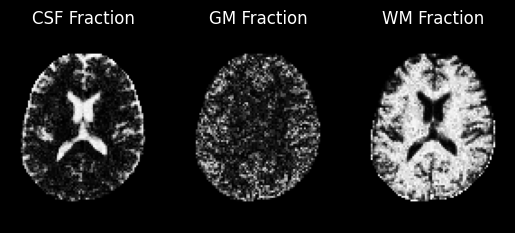

In [ ]:
# plot an axial middle slice for all the tissue maps
axial_middle_slice = mask.shape[2] // 2
plt.figure(facecolor='black')
ax1 = plt.subplot(1,3,1)
ax1.imshow(fw[:,:,axial_middle_slice].T, cmap='gray', origin='lower')
ax1.set_title('CSF Fraction', color='white')
ax1.axis('off')
ax2 = plt.subplot(1,3,2)
ax2.imshow(gm_fraction[:,:,axial_middle_slice].T, cmap='gray', origin='lower')
ax2.set_title('GM Fraction', color='white')
ax2.axis('off')
ax3 = plt.subplot(1,3,3)
ax3.imshow(wm_fraction[:,:,axial_middle_slice].T, cmap='gray', origin='lower')
ax3.set_title('WM Fraction', color='white')
ax3.axis('off')
plt.show()




## Visualization: NODDI Metrics

Visualization of NODDI (Neurite Orientation Dispersion and Density Imaging) metrics:
- **ND (Neurite Density)**: Density of neurites (axons and dendrites)
- **ODI (Orientation Dispersion Index)**: Measure of fiber orientation dispersion
- **CSF Fraction**: Free water fraction

These metrics provide insights into tissue microstructure and organization.


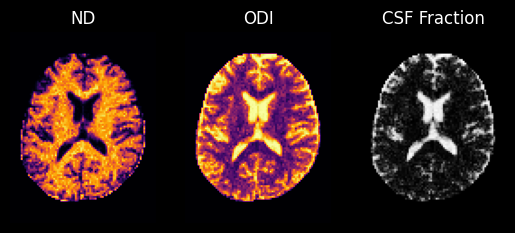

In [ ]:
# get the 3 noddi maps 

plt.figure(facecolor='black')
ax1 = plt.subplot(1,3,1)
ax1.imshow(nd[:,:,axial_middle_slice].T, cmap='inferno', origin='lower')
ax1.set_title('ND', color='white')
ax1.axis('off')
ax2 = plt.subplot(1,3,2)
ax2.imshow(odi[:,:,axial_middle_slice].T, cmap='inferno', origin='lower')
ax2.set_title('ODI', color='white')
ax2.axis('off')
ax3 = plt.subplot(1,3,3)
ax3.imshow(fw[:,:,axial_middle_slice].T, cmap='gray', origin='lower')
ax3.set_title('CSF Fraction', color='white')
ax3.axis('off')
plt.show()



## Visualization: DTI Metrics

Visualization of Diffusion Tensor Imaging (DTI) metrics:
- **FA (Fractional Anisotropy)**: Measure of diffusion directionality (0 = isotropic, 1 = fully anisotropic)
- **MD (Mean Diffusivity)**: Average diffusion coefficient
- **RD (Radial Diffusivity)**: Diffusion perpendicular to the principal direction
- **AD (Axial Diffusivity)**: Diffusion along the principal direction

These metrics are computed from the matched simulation library and provide complementary information to NODDI metrics.


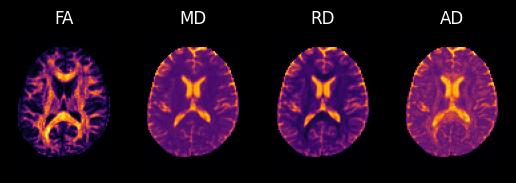

In [ ]:
# get the DTI maps
plt.figure(facecolor='black')
ax1 = plt.subplot(1,4,1)
ax1.imshow(fa[:,:,axial_middle_slice].T, cmap='inferno', origin='lower')
ax1.set_title('FA', color='white')
ax1.axis('off')
ax2 = plt.subplot(1,4,2)
ax2.imshow(md[:,:,axial_middle_slice].T, cmap='inferno', origin='lower')
ax2.set_title('MD', color='white')
ax2.axis('off')
ax3 = plt.subplot(1,4,3)
ax3.imshow(rd[:,:,axial_middle_slice].T, cmap='inferno', origin='lower')
ax3.set_title('RD', color='white')
ax3.axis('off')
ax4 = plt.subplot(1,4,4)
ax4.imshow(ad[:,:,axial_middle_slice].T, cmap='inferno', origin='lower')
ax4.set_title('AD', color='white')
ax4.axis('off')
plt.show()




## Visualization: Uncertainty and Ambiguity Maps

Visualization of matching quality metrics:
- **Uncertainty**: Interquartile range (IQR) of similarity scores for the top matches. Higher values indicate less confidence in the match.
- **Ambiguity**: Fraction of matches above half-maximum similarity. Higher values indicate multiple similar matches, suggesting ambiguous fiber configurations.

These maps help identify regions where the matching results may be less reliable.


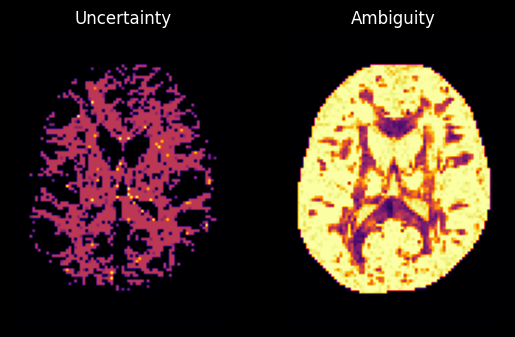

In [ ]:
# get the uncertainty and ambiguity maps
plt.figure(facecolor='black')
ax1 = plt.subplot(1,2,1)
ax1.imshow(uncertainty[:,:,axial_middle_slice].T, cmap='inferno', origin='lower')
ax1.set_title('Uncertainty', color='white')
ax1.axis('off')
ax2 = plt.subplot(1,2,2)
ax2.imshow(ambiguity[:,:,axial_middle_slice].T, cmap='inferno', origin='lower')
ax2.set_title('Ambiguity', color='white')
ax2.axis('off')
plt.show()